In [8]:
!pip install tweepy

In [9]:
#Importing Libraries
import tweepy
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import json
from collections import Counter

In [10]:
#Part-1: Authorization and Search tweets
#Getting authorization
consumer_key = 'p6Fg6WjZeOIQN1FvrsnvCfcbo'
consumer_key_secret = '7sgTYd66QCOoaEDuOXSoH5TkoTJrzmWvjEDnVdIaO7tqZgeGhg'
access_token = '132425188-3pEgCTglpzvYC605OMINgGkn3fO5pTFMv2NfWY61'
access_token_secret = 'Qkzccwwbf6J4Mrpkem4LHVefHxBT13E3C28x0F8gufIyc'
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [14]:
#Defining Search keyword and number of tweets and searching tweets
query = 'COVID-19','anxiety'
max_tweets = 2000
searched_tweets = [status for status in tweepy.Cursor(api.search_tweets, q=query, lang="en").items(max_tweets)]

In [15]:
#Part-2: Sentiment Analysis Report

#Finding sentiment analysis (+ve, -ve and neutral)
pos = 0
neg = 0
neu = 0
for tweet in searched_tweets:
    analysis = TextBlob(tweet.text)
    if analysis.sentiment[0]>0:
       pos = pos +1
    elif analysis.sentiment[0]<0:
       neg = neg + 1
    else:
       neu = neu + 1
print("Total Positive = ", pos)
print("Total Negative = ", neg)
print("Total Neutral = ", neu)

In [16]:
#Plotting sentiments
labels = 'Positive', 'Negative', 'Neutral'
sizes = [257, 223, 520]
colors = ['#a2c9f4', '#8ee5a1', '#fe9f9b']
explode = (0.1, 0, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

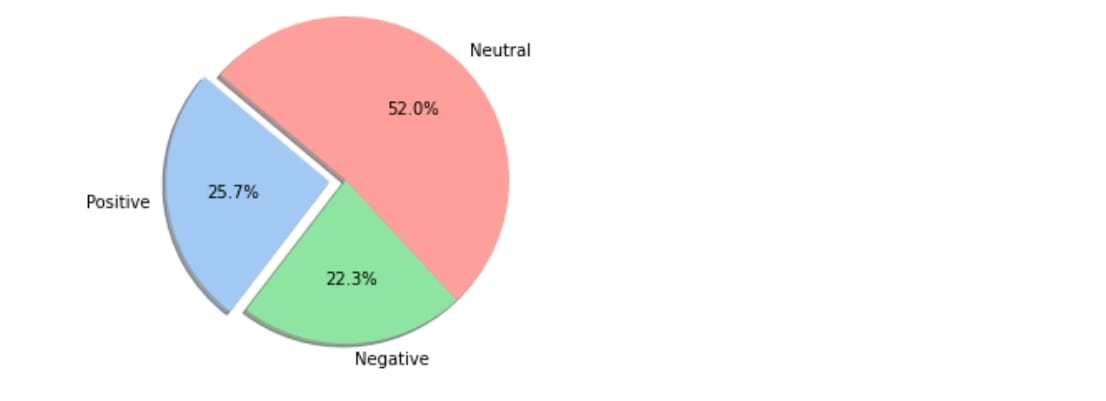!

In [17]:
#Part-3: Creating Dataframe of Tweets

#Cleaning searched tweets and converting into Dataframe
my_list_of_dicts = []
for each_json_tweet in searched_tweets:
    my_list_of_dicts.append(each_json_tweet._json)
    
with open('tweet_json_Data.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))
        
my_demo_list = []
with open('tweet_json_Data.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        text = each_dictionary['text']
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        created_at = each_dictionary['created_at']
        my_demo_list.append({'tweet_id': str(tweet_id),
                             'text': str(text),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'created_at': created_at,
                            })
        
        tweet_dataset = pd.DataFrame(my_demo_list, columns = 
                                  ['tweet_id', 'text', 
                                   'favorite_count', 'retweet_count', 
                                   'created_at'])
    
#Writing tweet dataset to csv file for future reference
tweet_dataset.to_csv('tweet_data.csv')

In [60]:
tweet_dataset.to_csv('/kaggle/working/tweet_data.csv')

In [18]:
tweet_dataset.shape

In [19]:
tweet_dataset.head(20)

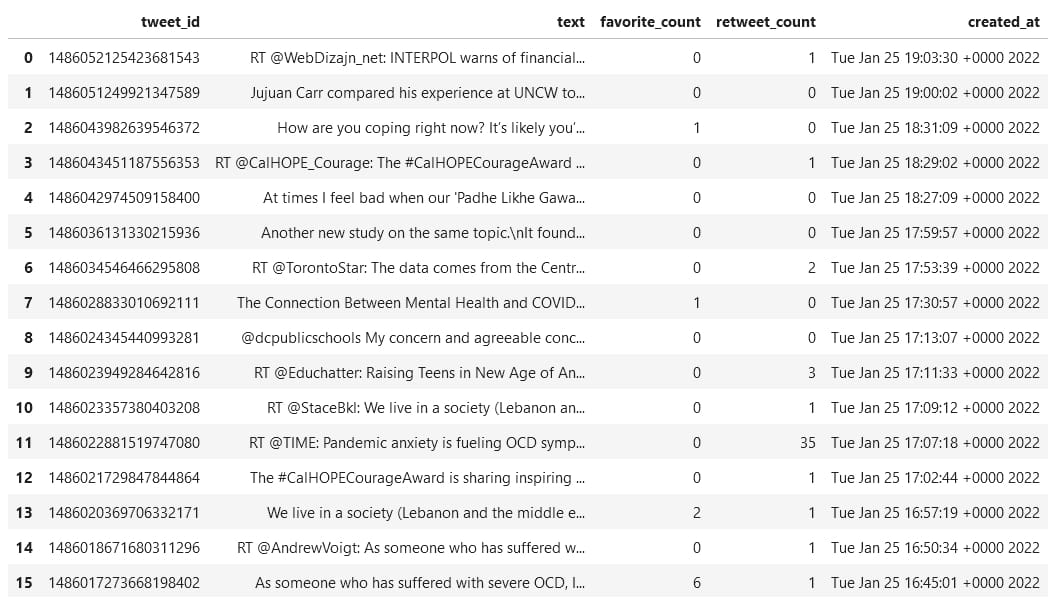

In [20]:
#part 4 - Cleaning Data

#Removing @ handle
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

tweet_dataset['text'] = np.vectorize(remove_pattern)(tweet_dataset['text'], "@[\w]*")

In [21]:
tweet_dataset.head()

In [22]:
tweet_dataset['text'].head(10)

In [23]:
#Cleaning Tweets
corpus = []
for i in range(0, 1000):
    tweet = re.sub('[^a-zA-Z0-9]', ' ', tweet_dataset['text'][i])
    tweet = tweet.lower()
    tweet = re.sub('rt', '', tweet)
    tweet = re.sub('http', '', tweet)
    tweet = re.sub('https', '', tweet)
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

In [33]:
from wordcloud import STOPWORDS
from PIL import Image

In [56]:
#Part-5: Visualization

# #Word Cloud
mask = np.array(Image.open('../input/twitterlogo/twitter.jpg'))
all_words = ' '.join([text for text in corpus])
wordcloud = WordCloud(background_color='#004481',colormap='Pastel1',mask=mask,
                      contour_width=1, contour_color='white'
                      ,collocations=False,stopwords=STOPWORDS,
                      width=800, height=500, random_state=21,
                      max_font_size=150).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

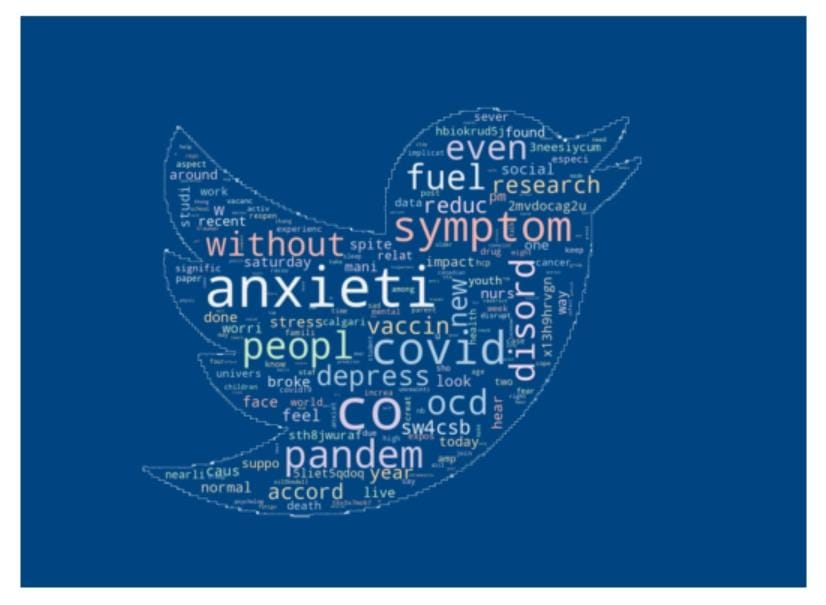

In [57]:
#Term Freuency - TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(tweet_dataset['text'])
#Count Most Frequent Words
Counter = Counter(corpus)
most_occur = Counter.most_common(10) 
print(most_occur)